#### Kaggle home credit default risk dataset

Attempt to predict if a customer will default on their payments from various lifestyle characteristics. This is an example of an anomaly identification problem.

We investiage a few different classfiers: RandomForest produces high scores, but these are deciptive because the number of true negatives is so high. The random forest actually does a very poor job of classifiying the default cases correctly.

SVMs might be a better option, but these take a really long time to train. We try to get around this with a sampling experiment: Keep all of the positive instances and the downsample the negative instances until the class sizes are roughly equal. An SVM might then train in a reasonable time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#We shouldn't need this, since the labels in the target are just 0 and 1, but it is probably good
#practice to use it
from sklearn.preprocessing import LabelEncoder

In [3]:
application_train = pd.read_csv('application_train.csv')

The data is probably unbalanced. Lets see how severe this is

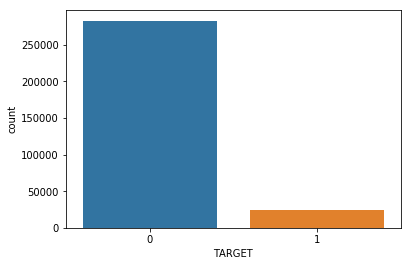

In [9]:
sns.countplot(application_train['TARGET'])
target = application_train['TARGET']

In [10]:
100*len(target[target==1])/len(target[target==0])

8.781828601345662

So about 9% of the data instances are positive. This is not quite as unbalanced as expected. Typically SMV classifiers work well with such data, but we can investigate a few different types

In [11]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We should investigate which columns have null values

In [12]:
application_train.isnull().sum()/len(application_train)

SK_ID_CURR                    0.000000
TARGET                        0.000000
NAME_CONTRACT_TYPE            0.000000
CODE_GENDER                   0.000000
FLAG_OWN_CAR                  0.000000
FLAG_OWN_REALTY               0.000000
CNT_CHILDREN                  0.000000
AMT_INCOME_TOTAL              0.000000
AMT_CREDIT                    0.000000
AMT_ANNUITY                   0.000039
AMT_GOODS_PRICE               0.000904
NAME_TYPE_SUITE               0.004201
NAME_INCOME_TYPE              0.000000
NAME_EDUCATION_TYPE           0.000000
NAME_FAMILY_STATUS            0.000000
NAME_HOUSING_TYPE             0.000000
REGION_POPULATION_RELATIVE    0.000000
DAYS_BIRTH                    0.000000
DAYS_EMPLOYED                 0.000000
DAYS_REGISTRATION             0.000000
DAYS_ID_PUBLISH               0.000000
OWN_CAR_AGE                   0.659908
FLAG_MOBIL                    0.000000
FLAG_EMP_PHONE                0.000000
FLAG_WORK_PHONE               0.000000
FLAG_CONT_MOBILE         

In [13]:
col_len = len(application_train)

In [14]:
#Drop all the columns with more than 10% NaNs
application_train.dropna(thresh=0.9*col_len,axis=1,inplace=True)

In [15]:
#Drop all the rows that contain NaN values
application_train.dropna(axis=0,inplace=True)

In [16]:
application_train.isnull().sum()

SK_ID_CURR                     0
TARGET                         0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_CREDIT                     0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
REGION_POPULATION_RELATIVE     0
DAYS_BIRTH                     0
DAYS_EMPLOYED                  0
DAYS_REGISTRATION              0
DAYS_ID_PUBLISH                0
FLAG_MOBIL                     0
FLAG_EMP_PHONE                 0
FLAG_WORK_PHONE                0
FLAG_CONT_MOBILE               0
FLAG_PHONE                     0
FLAG_EMAIL                     0
CNT_FAM_MEMBERS                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
          

I'm not sure what 'FLAG_DOCUMENT' is, so lets drop all these columns. We have plenty of data to work with even without these 21 columns. We will also need to convert most of the other columns to dummies so that we can run the classification properly.

In [17]:
dropcols = [name for name in application_train.columns if 'DOCUMENT' in name]

In [18]:
application_train.drop(dropcols,axis=1,inplace=True)

In [19]:
application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCI

In [20]:
application_train['REGION_POPULATION_RELATIVE'].head()

0    0.018801
1    0.003541
2    0.010032
3    0.008019
4    0.028663
Name: REGION_POPULATION_RELATIVE, dtype: float64

In [21]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,Business Entity Type 3,0.262949,2.0,2.0,2.0,2.0,-1134.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,School,0.622246,1.0,0.0,1.0,0.0,-828.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,Government,0.555912,0.0,0.0,0.0,0.0,-815.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,Business Entity Type 3,0.650442,2.0,0.0,2.0,0.0,-617.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,1,1,Religion,0.322738,0.0,0.0,0.0,0.0,-1106.0


Since most of these columns are string, we need to convert them to categorial variables for training. We can also choose a subset of the other columns to train on. This is not very rigorous at the moment - a better idea would be to use all the columns initially then use feature selection tools to refine the choice

In [22]:
contract_dummies = pd.get_dummies(application_train['NAME_CONTRACT_TYPE'],drop_first=True)
gender_dummies = pd.get_dummies(application_train['CODE_GENDER'],drop_first=True)
car_dummies = pd.get_dummies(application_train['FLAG_OWN_CAR'],drop_first=True)
children_count = application_train['CNT_CHILDREN']
total_income = application_train['AMT_INCOME_TOTAL']
total_credit = application_train['AMT_CREDIT']
total_annuity = application_train['AMT_ANNUITY']
total_goods_price = application_train['AMT_GOODS_PRICE']
age_days = application_train['DAYS_BIRTH'].apply(lambda x: -1*x)
employed_days = application_train['DAYS_EMPLOYED'].apply(lambda x: -1*x)
registered_days = application_train['DAYS_REGISTRATION'].apply(lambda x: -1*x)
family_members_count = application_train['CNT_FAM_MEMBERS']
realty_dummies = pd.get_dummies(application_train['FLAG_OWN_REALTY'],drop_first=True)
income_type_dummies = pd.get_dummies(application_train['NAME_INCOME_TYPE'],drop_first=True)
education_type_dummies = pd.get_dummies(application_train['NAME_EDUCATION_TYPE'],drop_first=True)
marriage_type_dummies = pd.get_dummies(application_train['NAME_FAMILY_STATUS'],drop_first=True)
house_type_dummies = pd.get_dummies(application_train['NAME_HOUSING_TYPE'],drop_first=True)
mobile_dummies = pd.get_dummies(application_train['FLAG_MOBIL'],drop_first=True)
email_dummies = pd.get_dummies(application_train['FLAG_EMAIL'],drop_first=True)
organization_type_dummies = pd.get_dummies(application_train['ORGANIZATION_TYPE'],drop_first=True)
target = application_train['TARGET']

We now need to concatinate these dataframes

In [23]:
df_training = pd.concat([contract_dummies,car_dummies],axis=1)
components = [gender_dummies,children_count,total_income,total_annuity,total_goods_price,total_credit,
     age_days,employed_days,registered_days,family_members_count,realty_dummies,income_type_dummies,
      education_type_dummies,marriage_type_dummies,house_type_dummies,mobile_dummies,email_dummies,
      organization_type_dummies,target]

for dataframe in components:  
    df_training = pd.concat([df_training,dataframe],axis=1)

Remove all rows there XNA == 1, since this indicates that there was an issue with formning the dummy variables

In [24]:
cnames = list(df_training.columns)
cnames[3] = 'XNA_1'
cnames[-2] = 'XNA_2'
df_training.columns = cnames
df_training = df_training[(df_training['XNA_1']==0) & (df_training['XNA_2']==0)].drop(
    ['XNA_1','XNA_2'],axis=1)

In [25]:
df_training.head()

,Revolving loans,Y,M,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_CREDIT,DAYS_BIRTH,DAYS_EMPLOYED,...,Trade: type 4,Trade: type 5,Trade: type 6,Trade: type 7,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,TARGET
0,0,0,1,0,202500.0,24700.5,351000.0,406597.5,9461,637,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,270000.0,35698.5,1129500.0,1293502.5,16765,1188,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,67500.0,6750.0,135000.0,135000.0,19046,225,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,135000.0,29686.5,297000.0,312682.5,19005,3039,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,121500.0,21865.5,513000.0,513000.0,19932,3038,...,0,0,0,0,0,0,0,0,0,0


We now need to change the labels of some of the keyes and scale the data. Then we can start testing classifiers

In [26]:
column_names = list(df_training.columns)
column_names[1] = 'Own car'
column_names[2] = 'Male'
column_names[12] = 'Own realty'
column_names[33] = 'Unknown' #this is not ideal - should try to fix later
df_training.columns = column_names

In [27]:
df_training.columns

Index(['Revolving loans', 'Own car', 'Male', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_CREDIT',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS',
       'Own realty', 'Commercial associate', 'Maternity leave', 'Pensioner',
       'State servant', 'Student', 'Unemployed', 'Working', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Secondary / secondary special',
       'Married', 'Separated', 'Single / not married', 'Widow',
       'House / apartment', 'Municipal apartment', 'Office apartment',
       'Rented apartment', 'With parents', 'Unknown', 'Agriculture', 'Bank',
       'Business Entity Type 1', 'Business Entity Type 2',
       'Business Entity Type 3', 'Cleaning', 'Construction', 'Culture',
       'Electricity', 'Emergency', 'Government', 'Hotel', 'Housing',
       'Industry: type 1', 'Industry: type 10', 'Industry: type 11',
       'Industry: type 12', 'Industry: type 13', 'Industry: type 2',

Since this dataset has wide range of column values, it might be good practice to scale it first before preoceeding. There are a few different scalers to investigate

In [28]:
target = df_training['TARGET']
df_training.drop('TARGET',axis=1,inplace=True)

In [29]:
le = LabelEncoder()

In [30]:
le.fit(target)
target_vals = le.transform(target)

In [31]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [32]:
#This removes the mean and scales to unit variance
df_standard_scaled = StandardScaler().fit_transform(df_training)
#This removes the median and scales to IQR
df_robust_scaled = RobustScaler().fit_transform(df_training)
#This scales features to a given range
df_minmax_scaled = MinMaxScaler().fit_transform(df_training)

In [33]:
#Lets start by using an SVM classfier to see what we get
from sklearn.svm import SVC, OneClassSVM
#need to do a train-test split
from sklearn.model_selection import train_test_split
#for error reporting
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
X_train, X_test, y_train, y_test = train_test_split(df_standard_scaled,target,test_size=0.3)

In [ ]:
%%time
clf = SVC(class_weight='balanced')
clf.fit(X_train,y_train)

This takes a long time to train!

In [36]:
#We can also try classification with a random forest 
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfc = RandomForestClassifier(class_weight='balanced',n_estimators=200)

In [46]:
%%time
rfc.fit(X_train,y_train)

CPU times: user 1min 30s, sys: 1.2 s, total: 1min 31s
Wall time: 1min 32s


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [47]:
train_score = rfc.score(X_train,y_train)
test_score = rfc.score(X_test,y_test)
print("Test score: %f, Train score: %f" %(train_score,test_score))

Test score: 1.000000, Train score: 0.912580


In [48]:
print(classification_report(y_test,rfc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     68352
          1       1.00      0.00      0.00      6551

avg / total       0.92      0.91      0.87     74903



Mean recall is higher than precision,vwhich might suggest that the model is better at dealing with false negatives than false positives. This is probably a good thing in this situation since a false negative is a customer who defaults but is predicted not to default - we want to avoud this as far as possible. HOWEVER! The recall for default predictions is 0.0! 

However lets look at the confusion matrix

In [49]:
print(confusion_matrix(y_test,rfc.predict(X_test)))

[[68352     0]
 [ 6548     3]]


This is really bad! There are only 3 true negatives predicted. Most of the times default occurences are missed and miscalssified as a non-default. Only 3 out of 6551 defaults are correctly identified! This highlights the fact that random forests is probably a bad choice with very unbalanced classification probems

In [ ]:
%%time
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)